## Xây dựng một ứng dụng di động mà khách hàng có thể sử dụng khi họ lên taxi để ước tính giá cước.

In [5]:
import pandas as pd

df = pd.read_csv('data/taxi-fares.csv', parse_dates=['pickup_datetime'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-06-15 17:11:00.000000107,7.0,2014-06-15 17:11:00+00:00,-73.995420,40.759662,-73.987607,40.751247,1
1,2011-03-14 22:43:00.00000095,4.9,2011-03-14 22:43:00+00:00,-73.993552,40.731110,-73.998497,40.737200,5
2,2011-02-14 15:14:00.00000067,6.1,2011-02-14 15:14:00+00:00,-73.972380,40.749527,-73.990638,40.745328,1
3,2009-10-29 11:29:00.00000040,6.9,2009-10-29 11:29:00+00:00,-73.973703,40.763542,-73.984253,40.758603,5
4,2011-07-02 10:38:00.00000028,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,1


1. Xem xét số lượng khách hàng cho mỗi chuyển đi

<Axes: xlabel='passenger_count', ylabel='count'>

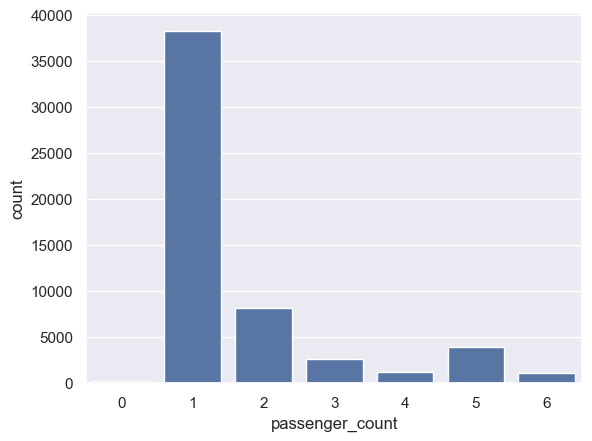

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set()

sns.countplot(x=df['passenger_count'])

Trong phạm vi của model này thì chúng ta sẽ tập trung dự đoán giá vé cho từng khách hàng cho nên ta sẽ tập trung vào các chuyến đi có 1 người khách

In [ ]:
df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)
df.shape

(38233, 6)

Tìm hiểu mức độ ảnh hưởng của các biến đầu vào với nhau bằng hàm corr()

In [8]:
corr_matrix = df.corr()
corr_matrix['fare_amount'].sort_values(ascending=False)

fare_amount          1.000000
pickup_datetime      0.115992
dropoff_longitude    0.020438
pickup_longitude     0.015742
pickup_latitude     -0.015915
dropoff_latitude    -0.021711
Name: fare_amount, dtype: float64

**Nhận xét:**
* Kinh độ và vĩ độ có vẻ như không liên quan nhiều đến giá vé. Tuy nhiên trong thực tế thì chúng phải có một mối quan hệ mạnh -> Có gì đó sai sai.

=> Chúng ta cần phải thực hiện thay đổi tập dữ liệu sau cho trong đó có chứa ngữ cảnh đầy đủ của các biến.

In [10]:
from math import sqrt

for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance

df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,day_of_week,pickup_time,distance
0,7.0,2014-06-15 17:11:00+00:00,-73.995420,40.759662,-73.987607,40.751247,6.0,17.0,0.720497
2,6.1,2011-02-14 15:14:00+00:00,-73.972380,40.749527,-73.990638,40.745328,0.0,15.0,1.038136
4,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,5.0,10.0,2.924341
5,15.3,2011-12-09 20:03:00+00:00,-73.973500,40.792610,-73.936035,40.856548,4.0,20.0,4.862893
8,7.7,2011-04-02 01:05:15+00:00,-73.979564,40.735405,-73.955686,40.768065,5.0,1.0,2.603493


1. Thêm các cột ngày trong tuần, giờ đưa đón - được tách ra từ cột pickup_datetime.
2. Hơn hết, ta chuyển khoảng cách bằng đường hàng không ( tính bằng dặm ).
3. Ta sẽ bỏ qua độ cong khoảng cách ( do đường cong của trái đất ), vì hầu hết các chuyển taxi đi với khoảng cách không quá xa :))

Sau khi thực hiện thêm ngữ cảnh xong thì ta tiến hành xóa các cột không sử dụng `pickup_datetime`, `pickup_longitude`, `pickup_latitude`,            `dropoff_longitude`, `dropoff_latitude`

In [11]:
df.drop(columns=['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
                 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
df.head()

,fare_amount,day_of_week,pickup_time,distance
0,7.0,6.0,17.0,0.720497
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493


In [12]:
# Kiểm tra lại mối tương quan giữa giá vé - fere_amount và các yếu tố khác
corr_matrix = df.corr()
corr_matrix['fare_amount'].sort_values(ascending=False)

fare_amount    1.000000
distance       0.045873
day_of_week    0.009196
pickup_time   -0.019722
Name: fare_amount, dtype: float64

**Nhận xét:**
* Sau khi thêm ngữ cảnh thì vẫn chưa có một mối quan hệ mạnh mẽ giữa khoảng cách và giá vé ở đây?

In [13]:
df.describe()

,fare_amount,day_of_week,pickup_time,distance
count,38233.000000,38233.000000,38233.000000,38233.000000
mean,11.214115,2.951534,13.387989,12.018397
std,9.703149,1.932809,6.446519,217.357022
min,-22.100000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,9.000000,0.762116
50%,8.500000,3.000000,14.000000,1.331326
75%,12.500000,5.000000,19.000000,2.402226
max,256.000000,6.000000,23.000000,4923.837280


**Nhận xét:**
* Còn tồn tại những ngoại lệ ( `tiền âm?` )

=> Tiến hành xử lý lại các ngoại lệ này

In [14]:
df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]

corr_matrix = df.corr()
corr_matrix['fare_amount'].sort_values(ascending=False)

fare_amount    1.000000
distance       0.851913
day_of_week   -0.003570
pickup_time   -0.023085
Name: fare_amount, dtype: float64

**Nhận xét:**
* Trong có vẻ là ok hơn rồi, vì hầu hết (85%) sự thay đổi về số tiền cước được giải thích bởi khoảng cách di chuyển. 
* Tuy nhiên, mối tương quan giữa ngày trong tuần, giờ trong ngày và số tiền cước vẫn còn yếu, nhưng điều đó không đáng ngạc nhiên vì khoảng cách di chuyển là yếu tố chính thúc đẩy giá cước taxi.
  * Nhưng ta vẫn sẽ giữ nguyên các cột đó vì vẫn có lý khi mất nhiều thời gian hơn để đi từ điểm A đến điểm B trong giờ cao điểm hoặc lưu lượng giao thông lúc 5:00 chiều thứ Sáu có thể khác với lưu lượng giao thông lúc 5:00 chiều thứ Bảy.

---

### Mô hình 1: Hồi quy tuyến tính

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

x = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']

model = LinearRegression()
cross_val_score(model, x, y, cv=5).mean()

np.float64(0.7258845061910318)

### Mô hình 2: Rừng ngẫu nhiên

In [16]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0)
cross_val_score(model, x, y, cv=5).mean()

np.float64(0.706157807448991)

### Mô hình 3: Gradient boosting machine

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=0)
cross_val_score(model, x, y, cv=5).mean()

np.float64(0.750496262408626)

**Nhận xét:**
* Ta thấy rằng Gradient Boosting cho ta hệ số score cao nhất với 0.7505.

=> Do đó ta sẽ sủ dụng gradient boosting để làm mô hình dự đoán giá taxi

In [18]:
model.fit(x,y)

GradientBoostingRegressor(random_state=0)

**Kiểm thử:**
* Ta sẽ sử dụng mô hình để thực hiện thử một dự đoán về giá vé cho một chuyến đi dài 2 dặm vào lúc 5:00 chiều một ngày thứ 6 hoặc 7.

In [19]:
model.predict(pd.DataFrame({ 'day_of_week': [4], 'pickup_time': [17],
                             'distance': [2.0] }))

array([11.49105571])

In [20]:
model.predict(pd.DataFrame({ 'day_of_week': [5], 'pickup_time': [17],
                             'distance': [2.0] }))

array([10.95309995])

**Nhận xét:**
* Ta có thể thấy giá vé vào một ngày thứ 6 sẽ cao hơn ngày thứ 7.
* Mặc khác, câu trả lời có hợp lý không khi dữ liệu đến từ taxi ở Thành phố New York? Khi đó ta hãy xem xét rằng lưu lượng giao thông vào giờ cao điểm có thể sẽ đông hơn vào chiều thứ Sáu so với chiều thứ Bảy.